# Variant effects


The goal of this analysis it to understand the distributions of variant effects based on lead variants with \_Posterior Probability >= 0.9 (variants that we are ~90% certain that are true causal variants for each phenotype)

## Protocol for obtaining analysis ready datasets

Check `Filtering protocol estimation` paragraph for the process how we came up with following criteria

### Gwas

1. Calculate number of unique (_variantId_, _traitFromSourceMappedIds_ ) pairs
2. Retain the pairs that have count >= 2 (are replicated across at least two GWAS studies)
3. Filter lead variants by `PosteriorProbability >= 0.9` to retain only variants with high probability of being phenotype.

### molQTLs

1. Calculate the number of unique (_variantId_, _geneId_ - from studyIndex) pairs
2. Retain the pairs that have count >= 2 (are replicated across at least two molQTL studies)
3. Filter lead variants by `PosteriorProbability >= 0.9` to retain only variants with high probability of affecting molecular trait

#### pQTL

1. Split the dataset to `cis` and `trans` while plotting

## Plotting

1. Calculate the number of lead variants with PIP >= 0.9 -> prepare the dataset
1. Make a barplot of the counts of lead variants with PIP >= 0.9 based on the studyType and finemapping method
1. Create a piechart for each studyType that has the number of variants based on the VEP score classes (%, n)
1. Create a piechart for each MAF threshold (rare, low freq, common) that has the number of variants based on the VEP score classes (%, n)
1. Create a piechart for each (abs(estimated beta) >= 0.5) group(s) that has the number of variants based on the VEP score classes (%, n)
1. Extract the lead variants that have a high possibility of being within regulatory regions - based on the VEP scoring - classify by regulatory regions using interval datasets
1. Create a piechart for each interval datasets


## Setup


In [2]:
from __future__ import annotations

import random
from collections.abc import Callable

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.patches import Patch, Rectangle


In [3]:
random.seed(42)
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("coolwarm"))
pl.Config.set_tbl_rows(100)


polars.config.Config

### Methods


In [161]:
def classify_by_pip_threshold(pip: pl.Expr, threshold: float = 0.9) -> pl.Expr:
    """Classify dataset by posteriorProbability threshold."""
    return pl.when(pip >= threshold).then(True).otherwise(False).alias(f"is{threshold * 100:.0f}pip")


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


class VariantFrequencyGroup:
    def __init__(self, condition: Callable[[pl.Expr], pl.Expr], label: str) -> None:
        self.label = label
        self.condition = condition


def classify_by_maf(maf: pl.Expr, frequency_groups: list[VariantFrequencyGroup] | None = None) -> pl.Expr:
    """Classify variants based on the maf thresholds."""
    if not frequency_groups:
        frequency_groups = [
            VariantFrequencyGroup(
                lambda maf: (maf >= 0.01), "common"
            ),  # in case of adding lowFrequency change the threshold
            # VariantFrequencyGroup(lambda maf: ((maf <= 0.05) & (maf >= 0.01)), "lowFrequency"),
            VariantFrequencyGroup(lambda maf: (maf < 0.01), "rare"),
        ]

    maf = pl.col("majorPopulationMAF")
    expr = pl.when(False).then(None)
    for group in frequency_groups:
        expr = expr.when(group.condition(maf)).then(pl.lit(group.label))
    return expr.alias("MAFClass")


def classify_by_est_beta(est_beta: pl.Expr, beta_threshold: float | None = None) -> pl.Expr:
    """Classify the estimated beta by given threshold."""
    if not beta_threshold:
        beta_threshold = 0.5
    expr = (
        pl.when(est_beta.abs() >= beta_threshold)
        .then(pl.lit(f">={beta_threshold:.1f}"))
        .otherwise(pl.lit(f"<{beta_threshold:.1f}"))
    )
    return expr.alias("estBetaClass")


def adjust_study_type(study_type: pl.Expr) -> pl.Expr:
    """Adjust study type based on qtl distance type."""
    qtl_distance_type = (
        pl.when(pl.col("isTransQtl"))
        .then(pl.lit("trans"))
        .when(~pl.col("isTransQtl"))
        .then(pl.lit("cis"))
        .otherwise(pl.lit(None))
    )
    adjusted_study_type = (
        pl.when(study_type == "pqtl")
        .then(pl.concat_str(qtl_distance_type, study_type, separator="-"))
        .otherwise(study_type)
        .alias("studyType")
    )
    return adjusted_study_type


def prepare_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """Prefilter based on (7) criteria before the main analysis."""
    initial_n = df.shape[0]
    study_type = pl.col("studyType")

    var_id = pl.col("variantId")
    trait_id = (
        pl.when(study_type == "gwas")
        .then(pl.col("traitFromSourceMappedIds").list.sort().list.join(separator=";"))
        .otherwise(pl.col("geneId"))
        .alias("traitId")
    )
    credible_set_id = pl.concat_str(var_id, trait_id, separator=":").alias("credibleSetId")
    credible_set_id_count = pl.len().over(credible_set_id).alias("credibleSetIdCount")
    df = df.with_columns(var_id, trait_id, credible_set_id, credible_set_id_count)
    # apply filtering
    df = (
        df.filter(pl.col("posteriorProbability") >= 0.9)
        .filter(pl.col("credibleSetIdCount") >= 2)
        .unique(pl.col("credibleSetId"))
    )
    following_n = df.shape[0]
    print(f"Initial number of variants: {initial_n}")
    print(f"Following number of variants: {following_n}")
    print(f"Number of variants removed: {initial_n - following_n}")
    print(f"Percentage of variants removed: {(initial_n - following_n) / initial_n:.2%}")
    return df


class StudyType:
    def __init__(self, study_type: str, n: int):
        self.study_type = study_type
        self.n = n

    def __eq__(self, other: StudyType) -> bool:
        return self.n == other.n

    def __lt__(self, other: StudyType) -> bool:
        return self.n < other.n

    def __gt__(self, other: StudyType) -> bool:
        return self.n > other.n


def aggregate_by_variant_score_and_cond(df: pl.DataFrame, cond: pl.Expr) -> pl.DataFrame:
    """Aggregate counts and % of dataset rows on the vepScoreClass and conditional variable."""
    df = (
        df.with_columns(pl.col("vepEffect").struct.unnest())
        .group_by(pl.col("vepScoreClass"), cond)
        .agg(pl.len().alias("count"), pl.col("normalisedScore").first().alias("normalisedScore"))
        .select(
            pl.col("vepScoreClass"),
            cond,
            pl.col("count"),
            pl.col("normalisedScore"),
            ((pl.col("count") / pl.col("count").sum().over(cond)) * 100).round(2).alias("%"),
        )
        .select("count", "vepScoreClass", "normalisedScore")
        .sort("normalisedScore")
    )
    return df


def get_legend_components(data: pl.DataFrame, wedges) -> tuple:
    """Get the legend components based on data and wedges."""
    labels = (
        data.select(pl.concat_str(pl.col("vepScoreClass"), pl.col("normalisedScore").round(3), separator=" - "))
        .to_series()
        .to_list()
    )
    colors = [w.get_facecolor() for w in wedges]
    handlers = [Patch(facecolor=colors[i], label=labels[i]) for i in range(len(labels))]
    return (labels, colors, handlers)


## Dataset

The dataset contains lead variants, was created by 01 and 02 notebooks.


In [119]:
dataset = pl.read_parquet("../../data/rescaled-betas.parquet").with_columns(
    adjust_study_type(pl.col("studyType")),
    classify_by_maf(pl.col("majorPopulationMAF")),
    classify_by_vep_score(pl.col("vepEffect")),
    classify_by_est_beta(pl.col("rescaledStatistics").struct.field("estimatedBeta")),
)


## Filtering protocol estimation

Analysis done to verify which filtering protocol best suites the variant effect analysis. Dataset was limited to **lead variants from GWAS** study type.

Following protocols were checked:

1. Filter lead variants by `PosteriorProbability >= 0.9`
2. No filtering
3. Filter lead variants by `replicated(traitFromSourceMappedIds,variantId)>=2` and `deduplicate(efo, variantId)`
4. Filter lead variants by `PosteriorProbability >= 0.9` and `deduplicate(efo, variantId)`
5. Filter lead variants by `PosteriorProbability >= 0.9` and `deduplicate(variantId)`
6. Filter lead variants by `replicated(variantId)>=2` and `deduplicate(efo, variantId)`
7. Filter lead variants by `replicated(traitFromSourceMappedIds,variantId)>=2` and filter by `PosteriorProbability >= 0.9`, and `deduplicate(efo, variantId)`


#### Converter


In [ ]:
class GWASDatasetConverter:
    """Estimate the variant effect prediciton scores change when different filtering protocols are applied."""

    def __init__(self, dataset: pl.DataFrame) -> None:
        var_efo_id = pl.concat_str(
            pl.col("traitFromSourceMappedIds").list.join(";"),
            pl.col("variantId"),
            separator=";",
        ).alias("varEfoId")
        var_efo_id_dup_count = pl.len().over(var_efo_id).alias("varEfoPairCount")
        var_dup_count = pl.len().over("variantId").alias("variantIdCount")
        self.dataset = dataset.filter(pl.col("studyType") == "gwas").select(
            "*",
            var_efo_id,
            var_efo_id_dup_count,
            var_dup_count,
        )
        self.preparation_methods = {
            "pip>=0.9": self.filter_by_pip,
            "nofilter": self.no_filter,
            "replicated(efo,var)>=2;dedup(efo,var)": self.filter_by_replicated_efo_var_dedup_efo_var,
            "pip>=0.9;dedup(efo,var)": self.filter_by_pip_dedup_efo_var,
            "pip>=0.9;dedup(var)": self.filter_by_pip_dedup_var,
            "replicated(var)>=2;dedup(efo,var)": self.filter_by_replicated_var_dedup_efo_var,
            "replicated(var,efo);pip>=0.9;dedup(var,efo)": self.filter_by_pip_rep_dedup,
        }

    @staticmethod
    def filter_by_pip(df: pl.DataFrame) -> pl.DataFrame:
        dataset = df.filter(pl.col("posteriorProbability") >= 0.9)
        return dataset

    @staticmethod
    def no_filter(df: pl.DataFrame) -> pl.DataFrame:
        return df

    @staticmethod
    def filter_by_replicated_efo_var_dedup_efo_var(df: pl.DataFrame) -> pl.DataFrame:
        dataset = df.filter(pl.col("varEfoPairCount") >= 2).unique(subset="varEfoId", keep="first")
        return dataset

    @staticmethod
    def filter_by_pip_dedup_efo_var(df: pl.DataFrame) -> pl.DataFrame:
        dataset = df.filter(pl.col("posteriorProbability") >= 0.9).unique(subset="varEfoId", keep="first")
        return dataset

    @staticmethod
    def filter_by_pip_rep_dedup(df: pl.DataFrame) -> pl.DataFrame:
        dataset = (
            df.filter(pl.col("posteriorProbability") >= 0.9)
            .filter(pl.col("varEfoPairCount") >= 2)
            .unique(subset="varEfoId", keep="first")
        )
        return dataset

    @staticmethod
    def filter_by_pip_dedup_var(df: pl.DataFrame) -> pl.DataFrame:
        dataset = df.filter(pl.col("posteriorProbability") >= 0.9).unique(subset="variantId", keep="first")
        return dataset

    @staticmethod
    def filter_by_replicated_var_dedup_efo_var(df: pl.DataFrame) -> pl.DataFrame:
        dataset = df.filter(pl.col("variantIdCount") >= 2).unique(subset="varEfoId", keep="first")
        return dataset

    def apply_preparation_methods(self) -> dict[str, pl.DataFrame]:
        """Apply the preparation methods to the dataset."""
        return {method: func(self.dataset) for method, func in self.preparation_methods.items()}


#### Protocol selection


pip>=0.9 (186252, 28)
nofilter (576421, 28)
replicated(efo,var)>=2;dedup(efo,var) (78320, 28)
pip>=0.9;dedup(efo,var) (132521, 28)
pip>=0.9;dedup(var) (65770, 28)
replicated(var)>=2;dedup(efo,var) (268002, 28)
replicated(var,efo);pip>=0.9;dedup(var,efo) (31882, 28)
Total: 186252 method pip>=0.9
Total: 576421 method nofilter
Total: 78320 method replicated(efo,var)>=2;dedup(efo,var)
Total: 132521 method pip>=0.9;dedup(efo,var)
Total: 65770 method pip>=0.9;dedup(var)
Total: 268002 method replicated(var)>=2;dedup(efo,var)
Total: 31882 method replicated(var,efo);pip>=0.9;dedup(var,efo)


Text(0.5, 1.05, '95 credible set GWAS lead variants with protocol overview')

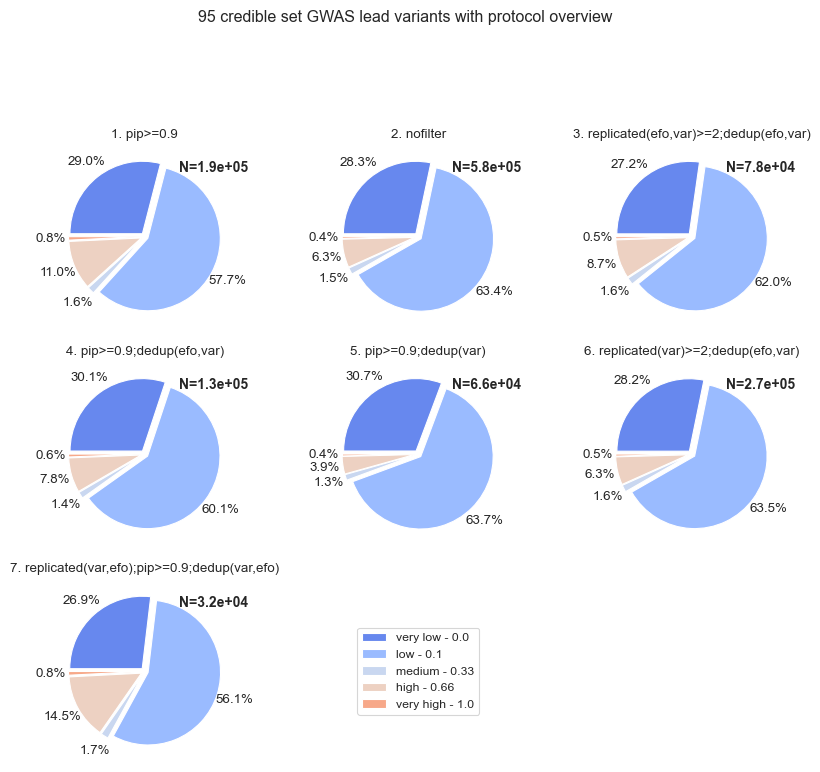

In [7]:
protocol_datasets = GWASDatasetConverter(dataset).apply_preparation_methods()

for method, df in protocol_datasets.items():
    print(method, df.shape)
fig = plt.figure(figsize=(10, 8))
i = 1
for method, df in protocol_datasets.items():
    df = (
        df.select("*", classify_by_vep_score(pl.col("vepEffect")), pl.col("vepEffect").struct.unnest())
        .group_by(pl.col("vepScoreClass"), pl.col("studyType"))
        .agg(pl.len().alias("count"), pl.col("normalisedScore").first().alias("normalisedScore"))
        .select(
            "vepScoreClass",
            "studyType",
            "count",
            "normalisedScore",
            ((pl.col("count") / pl.col("count").sum().over("studyType")) * 100).round(2).alias("%"),
        )
        .sort("normalisedScore")
    )
    ax = fig.add_subplot(3, 3, i)

    ax.set_title(f"{i}. {method}")
    x = df.select("count").to_series().to_numpy()
    labels = (
        df.select(pl.concat_str(pl.col("vepScoreClass"), pl.col("normalisedScore").round(3), separator=" - "))
        .to_series()
        .to_list()
    )
    n = sum(x)
    print(f"Total: {n} method {method}")
    wedges, *_ = ax.pie(
        x=x,
        counterclock=False,
        autopct="%1.1f%%",
        pctdistance=1.25,
        labeldistance=0.6,
        explode=(0.05,) * len(x),
        radius=1.0,
        startangle=180,
    )
    ax.text(
        0.95,
        0.95,
        f"N={n:.1e}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
    )
    i += 1


# Extract colors from the wedges
colors = [w.get_facecolor() for w in wedges]
legend_elements = [Patch(facecolor=colors[i], label=labels[i]) for i in range(len(labels))]
ax = fig.add_subplot(3, 3, 8)
ax.axis("off")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=legend_elements, loc="center")  # Place legend in next subplot
fig.suptitle("95 credible set GWAS lead variants with protocol overview", y=1.05)


### Results

We want to create a protocol for filtering lead variants based on the filtering in (7) (consists of most variants with _high_ and _very high_ variant effect predictor score classes)


## Lead variants with PIP >= 0.9

Analysis performed to understand the distribution of `PosteriorProbability` derived from lead variants


In [8]:
dataset_pip = dataset.select("*", classify_by_pip_threshold(pl.col("posteriorProbability")))


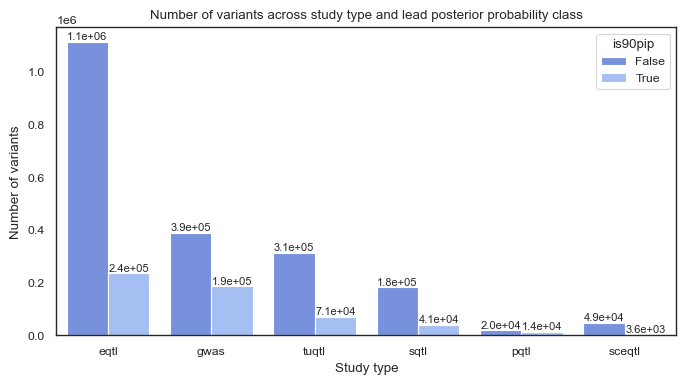

In [9]:
data = dataset_pip.select("is90pip", "studyType", "variantId")
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
sns.countplot(data=data, x="studyType", hue="is90pip", ax=ax)
ax.set_title("Number of variants across study type and lead posterior probability class")
ax.set_ylabel("Number of variants")
ax.set_xlabel("Study type")
for p in ax.patches:
    if isinstance(p, Rectangle):
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.1e}",
                (p.get_x() + p.get_width() / 2.0, height),
                ha="center",
                va="bottom",
                fontsize=8,
            )
plt.show()


We can also look at the distribution of the posterior probability for the lead variants


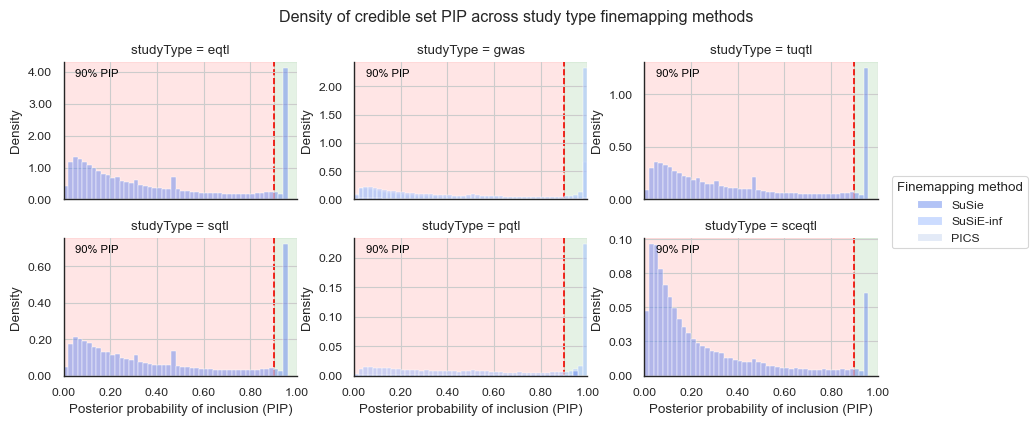

In [10]:
data = dataset_pip.select("posteriorProbability", "studyType", "is90pip", "finemappingMethod")
grid = sns.displot(
    data=data,
    x="posteriorProbability",
    hue="finemappingMethod",
    col="studyType",
    col_wrap=3,
    stat="density",
    bins=50,
    height=2,
    aspect=1.5,
    facet_kws={"sharey": False},
)
for ax in grid.axes.flatten():
    if isinstance(ax, Axes):
        ax.set_zorder(10)
        ax.set_xlabel("Posterior probability of inclusion (PIP)")
        ax.set_ylabel("Density")
        ax.set_xlim(0, 1)
        study_type = ax.get_title().split("=")[1].strip()
        ax.xaxis.set_major_formatter("{x:.2f}")
        ax.yaxis.set_major_formatter("{x:.2f}")
        ax.axvline(0.9, color="red", linestyle="--", zorder=-10)
        ax.axvspan(0, 0.9, color="red", alpha=0.1, zorder=-10)
        ax.axvspan(0.9, 1.0, color="green", alpha=0.1, zorder=-10)
        ax.grid(True)
        ax.text(0.05, 0.95, "90% PIP", color="black", fontsize=8, transform=ax.transAxes, ha="left", va="top")
legend = grid.legend
legend.set_title("Finemapping method")
legend.set_frame_on(True)

grid.figure.suptitle("Density of credible set PIP across study type finemapping methods", y=1.05)
plt.show()


## Variant Effect Prediction analysis

Initial dataset was prepared by following the (7) protocol. Additionally for grouping we have added following group variables:

- seven groups based on `studyType` and `isTransQtl` (`cis-pqtl`, `trans-pqtl`, `eqtl`, `seqtl`, `tuqtl` `sqtl` `gwas`)
- two groups created by splitting the dataset based on `abs(estimtedBeta) >= 0.5`
- two groups created by splitting the dataset into `rare` and `common` variants

The variant effects were splitted by the `vepEffect.normalisedScore` into 5 categories (`very low`, `low`, `moderate`, `high`, `very high`). See **Methods** for exact calculation.


### studyType vs VEP score


Initial number of variants: 384937
Following number of variants: 10162
Number of variants removed: 374775
Percentage of variants removed: 97.36%
Initial number of variants: 17680
Following number of variants: 11
Number of variants removed: 17669
Percentage of variants removed: 99.94%
Initial number of variants: 223507
Following number of variants: 6477
Number of variants removed: 217030
Percentage of variants removed: 97.10%
Initial number of variants: 52746
Following number of variants: 963
Number of variants removed: 51783
Percentage of variants removed: 98.17%
Initial number of variants: 576421
Following number of variants: 31885
Number of variants removed: 544536
Percentage of variants removed: 94.47%
Initial number of variants: 1349700
Following number of variants: 35860
Number of variants removed: 1313840
Percentage of variants removed: 97.34%
Initial number of variants: 16057
Following number of variants: 214
Number of variants removed: 15843
Percentage of variants removed: 98.6

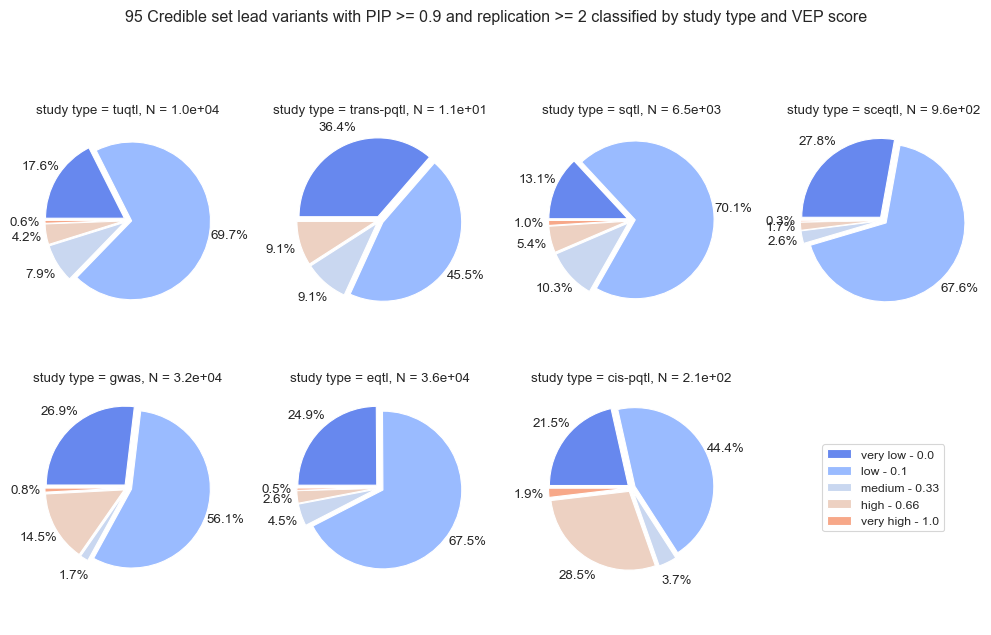

In [162]:
# Create the figure describing studyType classes (gwas, eqtl, cis-pqtl, trans-pqtl, sqtl, tuqtl, seqtl) vepScore distributions
fig = plt.figure(figsize=(10, 6))

# Extract conditioning variable
conditioning_col = pl.col("studyType")
conditioning_variable = dataset.select(conditioning_col).unique().to_series().to_list()
conditioning_variable.sort(reverse=True)


for idx, n in enumerate(conditioning_variable):
    ax = fig.add_subplot(2, 4, idx + 1)
    # Prefilter dataset before aggregations including studyType that the plot is conditionned on
    data = dataset.filter(conditioning_col == n)
    # Filter on replication(variantId, efo) >=2 and PIP >= 0.9
    data = prepare_dataset(data)
    # Aggregate on the conditionned variable and vepScoreClass
    data = aggregate_by_variant_score_and_cond(data, conditioning_col)
    x = data.select("count").to_series().to_numpy()
    N = data.select(pl.col("count").sum()).to_series()[0]
    ax.set_title(f"study type = {n}, N = {N:.1e}")
    wedges, *_ = ax.pie(
        x=x,
        counterclock=False,
        autopct="%1.1f%%",
        pctdistance=1.25,
        labeldistance=0.6,
        explode=(0.05,) * len(x),
        radius=1.0,
        startangle=180,
    )

# Plot legend
labels, _, handlers = get_legend_components(data, wedges)
ax = fig.add_subplot(2, 4, 8)
ax.axis("off")
ax.legend(handles=handlers, loc="center")  # Place legend in next subplot
fig.suptitle(
    "95 Credible set lead variants with PIP >= 0.9 and replication >= 2 classified by study type and VEP score", y=1.05
)

plt.tight_layout()
plt.show()


### MAF class vs VEP score


Initial number of variants: 531712
Following number of variants: 27691
Number of variants removed: 504021
Percentage of variants removed: 94.79%
Initial number of variants: 40182
Following number of variants: 3645
Number of variants removed: 36537
Percentage of variants removed: 90.93%


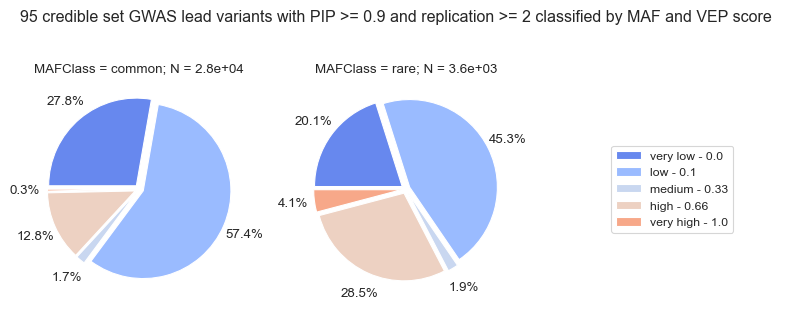

In [163]:
# Create the figure describing MAF classes (rare, common) vepScore distributions.
fig = plt.figure(figsize=(8, 3))

# Extract conditioning variable
study_type_col = pl.col("studyType")
maf_col = pl.col("majorPopulationMAF")
conditioning_col = pl.col("MAFClass")
conditioning_variable = (
    dataset.select(conditioning_col).filter(conditioning_col.is_not_null()).unique().to_series().to_list()
)
conditioning_variable.sort()

for idx, n in enumerate(conditioning_variable):
    ax = fig.add_subplot(1, 3, idx + 1)
    # Prefilter dataset before aggregations including only GWAS and MAFClass that the plot is conditionned on
    # NOTE! MAF can not be null nor zero if we want to make the plot accurate.
    data = (
        dataset.filter(study_type_col == "gwas")
        .filter(conditioning_col == n)
        .filter(maf_col.is_not_null())
        .filter(maf_col != 0.0)
    )
    # Filter on replication(variantId, efo) >=2 and PIP >= 0.9
    data = prepare_dataset(data)
    # Aggregate on the conditionned variable and vepScoreClass
    data = aggregate_by_variant_score_and_cond(data, conditioning_col)
    N = data.select(pl.col("count").sum()).to_series()[0]
    ax.set_title(f"MAFClass = {n}; N = {N:.1e}")
    x = data.select("count").to_series().to_numpy()
    wedges, *_ = ax.pie(
        x=x,
        counterclock=False,
        autopct="%1.1f%%",
        pctdistance=1.25,
        labeldistance=0.6,
        explode=(0.05,) * len(x),
        radius=1.0,
        startangle=180,
    )

# Plot legend
labels, _, handlers = get_legend_components(data, wedges)
ax = fig.add_subplot(1, 3, 3)
ax.axis("off")
ax.legend(handles=handlers, loc="center")  # Place legend in next subplot
fig.suptitle(
    "95 credible set GWAS lead variants with PIP >= 0.9 and replication >= 2 classified by MAF and VEP score", y=1.05
)
plt.tight_layout()
plt.show()


### Estimated beta vs vep score


Initial number of variants: 531597
Following number of variants: 28965
Number of variants removed: 502632
Percentage of variants removed: 94.55%
Initial number of variants: 35877
Following number of variants: 1739
Number of variants removed: 34138
Percentage of variants removed: 95.15%


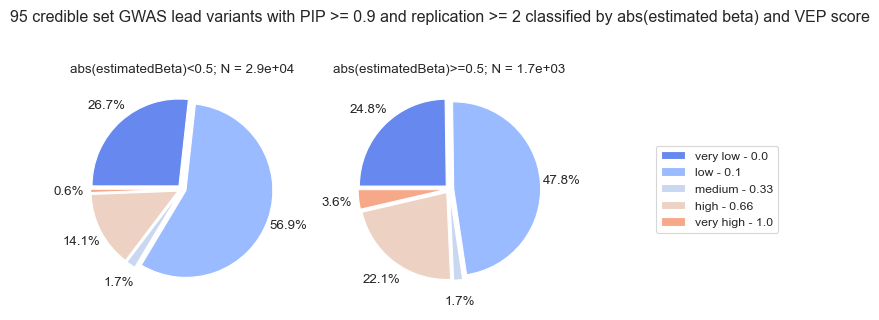

In [164]:
# Create the figure describing abs(estimatedBeta) classes (>=05, <0.5) vepScore distributions
fig = plt.figure(figsize=(8, 3))

# Extract conditioning variable
est_beta_col = pl.col("rescaledStatistics").struct.field("estimatedBeta")
study_type_col = pl.col("studyType")
conditioning_col = pl.col("estBetaClass")
conditioning_variable = dataset.select(conditioning_col).unique().to_series().to_list()
conditioning_variable.sort()


for idx, n in enumerate(conditioning_variable):
    ax = fig.add_subplot(1, 3, idx + 1)
    # Prefilter dataset before aggregations including studyType that the plot is conditionned on
    # NOTE! It is important to understand that `prepare_dataset` does not take into account divergent betas!
    # So in case the same variant efo pair has divergent betas, we will not be able to understand which is
    # true.
    data = (
        dataset.filter(study_type_col == "gwas")
        .filter(conditioning_col == n)
        .filter(est_beta_col.is_not_null())
        .filter(est_beta_col.is_finite())
    )
    # Filter on replication(variantId, efo) >=2 and PIP >= 0.9
    data = prepare_dataset(data)
    # Aggregate on the conditionned variable and vepScoreClass
    data = aggregate_by_variant_score_and_cond(data, conditioning_col)
    N = data.select(pl.col("count").sum()).to_series()[0]
    ax.set_title(f"abs(estimatedBeta){n}; N = {N:.1e}")
    x = data.select("count").to_series().to_numpy()
    wedges, *_ = ax.pie(
        x=x,
        counterclock=False,
        autopct="%1.1f%%",
        pctdistance=1.25,
        labeldistance=0.6,
        explode=(0.05,) * len(x),
        radius=1.0,
        startangle=180,
    )

# Plot legend
labels, _, handlers = get_legend_components(data, wedges)
ax = fig.add_subplot(1, 3, 3)
ax.axis("off")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handlers, loc="center")  # Place legend in next subplot
fig.suptitle(
    "95 credible set GWAS lead variants with PIP >= 0.9 and replication >= 2 classified by abs(estimated beta) and VEP score",
    y=1.05,
)
plt.tight_layout()
plt.show()


### Regulatory regions
